Bike sharing linear regression
---

Exercise - Load train/test sets & remove collinear features
---

> **Exercise**: Load the train/test sets into the `X_tr`, `y_tr`, `X_te` and `y_te` variables. Remove features that make the `X_tr` matrix, with the additional column of ones, rank deficient. Also, you might want to remove nearly collinear features if they hurt performance.

**Self-assessment**: Verify that the `X_tr` matrix with the additional column of ones has full rank. Compute its condition number.

In [1]:
import pandas as pd
import numpy as np

df_tr = pd.read_csv('data/bike-train.csv')
df_te = pd.read_csv('data/bike-test.csv')

df_tr.head(1)

,temp,temp_C,hum,windspeed,atemp,atemp_C,yr,workingday,holiday,casual
0,0.368,9.296,0.569,0.148,0.379,9.014,1,1,0,1603


In [2]:
# Extract X/y Numpy variables
X_tr = df_tr.drop(['casual'],axis=1).values
y_tr = df_tr.casual.values

X_te = df_te.drop('casual',axis=1).values
y_te = df_te.casual.values

# Verify that X_tr with the additional column of ones has full rank

rank = np.linalg.matrix_rank(X_tr)
print("Rank of the X_tr matrix:", rank)
print("Number of features:", X_tr.shape[1])

print("Rank is deficient, remove temp_C column")

X_tr = df_tr.drop(['casual','temp_C'],axis=1).values
rank = np.linalg.matrix_rank(X_tr)
print("Rank of the X_tr matrix:", rank)
print("Number of features:", X_tr.shape[1])

print("Rank is OK now")


# Compute its condition number
cond = np.linalg.cond(X_tr)
print("Condition score of X_tr matrix:", cond)
print("Condition score is too high, let's remove atemp_C column")

X_tr = df_tr.drop(['casual','temp_C','atemp_C', 'atemp'],axis=1).values
X1_tr = np.c_[np.ones(X_tr.shape[0]), X_tr]
cond = np.linalg.cond(X1_tr)
print("Condition score of X_tr matrix:", cond)

print("Condiditon score is OK")

# Do remove the same columns on the X_te matrix
X_te = df_te.drop(['casual','temp_C','atemp_C', 'atemp'],axis=1).values

Rank of the X_tr matrix: 8
Number of features: 9
Rank is deficient, remove temp_C column
Rank of the X_tr matrix: 8
Number of features: 8
Rank is OK now
Condition score of X_tr matrix: 964.1228749881127
Condition score is too high, let's remove atemp_C column
Condition score of X_tr matrix: 22.000828462946867
Condiditon score is OK


Exercise - Fit a linear regression model
---

> **Exercise**: (A) Fit a linear regression model to the `X_tr`, `y_tr` variables. Evaluate its performance on the test set using the mean absolute error (MAE). (B) Also, try fitting a linear regression with the Huber loss. (C) Pick one feature (e.g., temperatures) and plot the predictions from your best model (e.g., temperature vs. casual users plot).

**Note**: Your models might predict a negative number of users. In this case, you might want to set a lower limit with the Numpy `maximum()` function to improve performance, e.g. `y_pred = np.maximum(y_pred, 50)`.

In [3]:
# Compare models with mean absolute error (MAE)
def MAE(y, y_pred):
    return int(np.mean(np.abs(y-y_pred)))

MAE with Linear Regression: 288
MAE with Huber Loss Regression: 274
Will use Huber Loss model, coef =  [1890.7788357  -640.79925433 -955.93951862  167.43945833 -812.57566893
 -332.73405222]


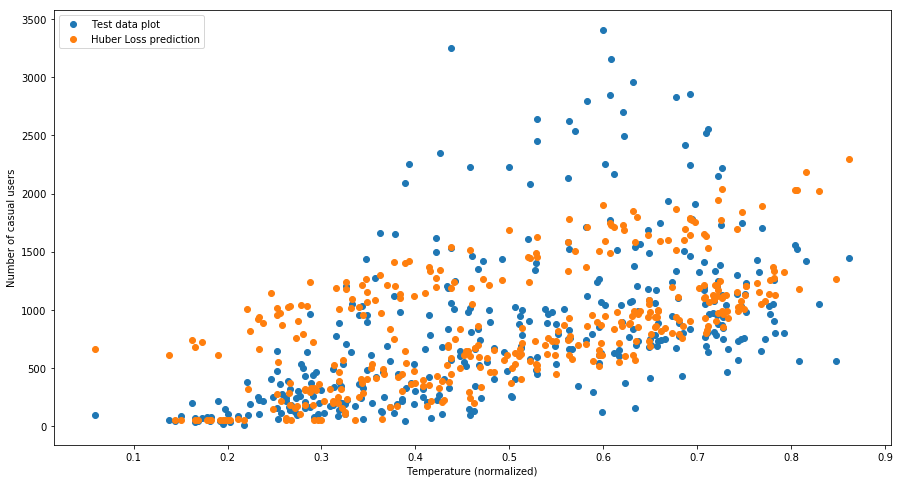

In [10]:
# (A) Fit and evaluate a linear regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_tr,y_tr)
y_pred_lr = lr.predict(X_te)

mae_lr = MAE(y_te,y_pred_lr)
print("MAE with Linear Regression:",mae_lr)

# (B) Same with Huber loss
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(epsilon=1.1)
huber.fit(X_tr,y_tr)
y_pred_huber = huber.predict(X_te)

y_pred_huber = np.maximum(y_pred_huber,50)

mae_huber = MAE(y_te, y_pred_huber)
print("MAE with Huber Loss Regression:", mae_huber)

# (C) Plot best model

import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(15,8))
plt.scatter(X_te[:,0], y_te, label='Test data plot')


print("Will use Huber Loss model, coef = ",huber.coef_)

plt.scatter(X_te[:,0], y_pred_huber, label='Huber Loss prediction')

plt.xlabel("Temperature (normalized)")
plt.ylabel("Number of casual users")
plt.legend(loc='upper left')
plt.show()



Exercise - Separate sources and fit two linear regressions
---

We saw in the course that we can identify two sources in the data.

1. Data points collected during working days
1. Data points collected during non-working days

The goal of this exercise is to create a model for each source and see whether this improves performance.

> **Exercise**: Create a model for each source and evaluate the overall performance on the test set using MAE. Compare your models to a baseline using a bar chart.

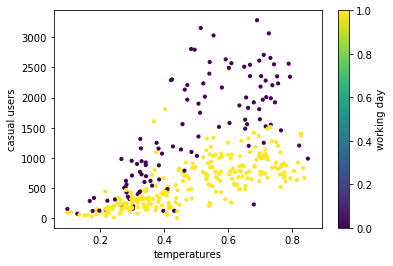

In [5]:
# We can identify two sources
temp_tr = X_tr[:, 0] # 0: temp column
wd_tr = X_tr[:, 4] # 4: workingday column

plt.scatter(temp_tr, y_tr, c=wd_tr, s=10)
plt.colorbar(label='working day')
plt.xlabel('temperatures')
plt.ylabel('casual users')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

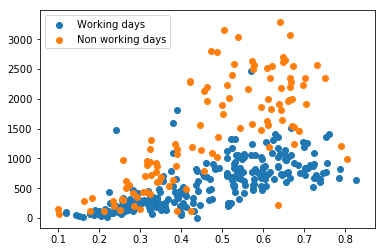

In [6]:
# Separate data points from the two sources
df_work_tr = df_tr[df_tr['workingday'] == 1]
df_nowork_tr = df_tr[df_tr['workingday'] != 1]

df_work_te = df_te[df_te['workingday'] == 1]
df_nowork_te = df_te[df_te['workingday'] != 1]

X_work_tr = df_work_tr.drop(['casual','temp_C','atemp_C','atemp','workingday'],axis=1).values
y_work_tr = df_work_tr['casual']

X_nowork_tr = df_nowork_tr.drop(['casual','temp_C','atemp_C','atemp','workingday'],axis=1).values
y_nowork_tr = df_nowork_tr['casual']


plt.scatter(df_work_tr['atemp'], y_work_tr,label='Working days')
plt.scatter(df_nowork_tr['atemp'], y_nowork_tr,label='Non working days')

plt.legend(loc='upper left')
plt.show

MAE on overall days: 247


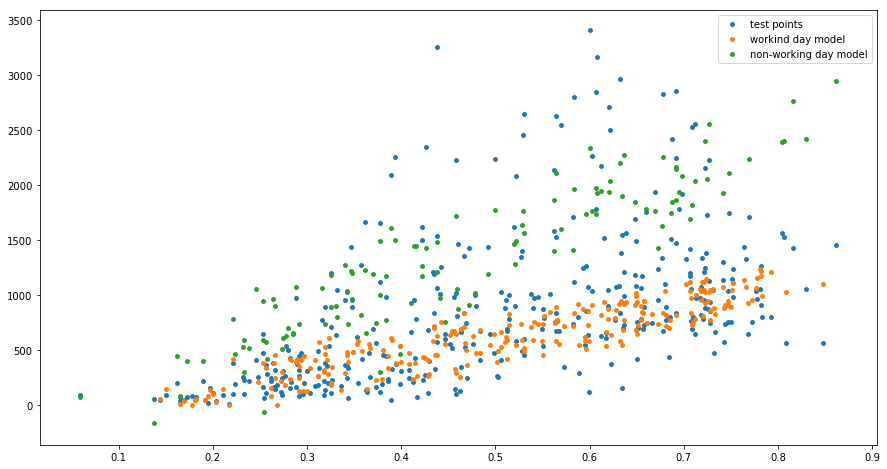

In [7]:
# Create a model for each one

lr_work = LinearRegression()
lr_nowork = LinearRegression()

lr_work.fit(X_work_tr,y_work_tr)
lr_nowork.fit(X_nowork_tr,y_nowork_tr)

# Evaluate the overall performance using MAE
X_work_te = df_work_te.drop(['casual','temp_C','atemp_C','atemp','workingday'],axis=1).values
y_work_te = df_work_te['casual']

X_nowork_te = df_nowork_te.drop(['casual','temp_C','atemp_C','atemp','workingday'],axis=1).values
y_nowork_te = df_nowork_te['casual']

y_work_pred = lr_work.predict(X_work_te)

y_nowork_pred = lr_nowork.predict(X_nowork_te)

# Concatenate all values and calculate MAE
X_allday_te = np.concatenate( (X_work_te, X_nowork_te) )
y_allday_te = np.concatenate( (y_work_te, y_nowork_te) )

y_allday_pred = np.concatenate( (y_work_pred, y_nowork_pred) )

mae_allday = MAE(y_allday_te,y_allday_pred)
print("MAE on overall days:",mae_allday)


# Plot temperatures for working days and non-working days
plt.figure(figsize=(15,8))
temp_allday_te = np.concatenate((X_work_te[:, 0], X_nowork_te[:, 0]))
plt.scatter(temp_allday_te, y_allday_te, s=15, label='test points')

# Predictions for working days
plt.scatter(X_work_te[:, 0], y_work_pred, s=15, label='workind day model')

# Predictions for non-working days
plt.scatter(X_nowork_te[:, 0], y_nowork_pred, s=15, label='non-working day model')

plt.legend()
plt.show()

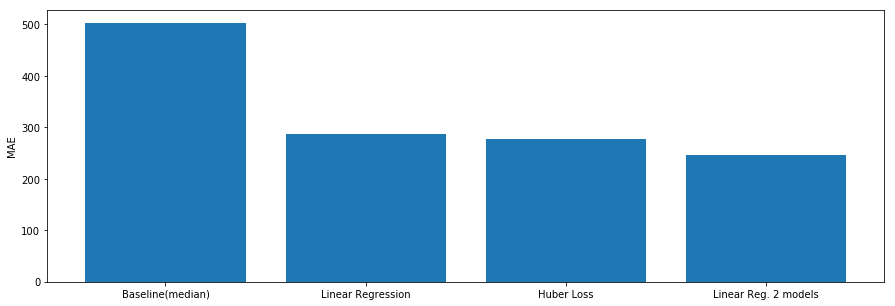

In [8]:
# Compare your models to a baseline using a bar chart

mae_baseline = MAE(y_te, np.median(y_tr))

# Final comparison
mae_values = [mae_baseline, mae_lr, mae_huber, mae_allday]
titles = ['Baseline(median)', 'Linear Regression', 'Huber Loss', 'Linear Reg. 2 models']

xcor = np.arange(len(mae_values))

plt.figure(figsize=(15,5))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()


Exercise - R^2 coefficient
---

> **Exercise**: Compute the $R^{2}$ coefficient of your different models on the test set.

In [9]:
# R2 coefficients
r2_lr = lr.score(X_te, y_te)
r2_huber = huber.score(X_te, y_te)

print('R^2 linear regression:', r2_lr)
print('R^2 huber loss:', r2_huber)

# R2 coefficient when separating sources
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

rss_allday = RSS(y_allday_te, y_allday_pred)
rss_baseline = RSS(y_te, y_te.mean())
r2_allday = 1 - rss_allday/rss_baseline

print('R^2 when separating sources:', r2_allday)

R^2 linear regression: 0.6680357017933192
R^2 huber loss: 0.6632551144362848
R^2 when separating sources: 0.7245579994599278
